### Import all relevant dependencies

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pathlib import Path
import pandas as pd
from src.minimizer.minimizer_library.differential_evolution_parallel import DifferentialEvolutionParallel
from src.minimizer.minimizer_library.cmaes import CMAESMinimizer
from src.minimizer.minimizer_library.shgo import SHGO
from src.visualization.plotting_functions import *
from src.statistical_models.statistical_model_library.fcs_gaussian_noise_model import FCSGaussianNoiseModel
from src.utils.experiment_serialization import import_all_experiments, import_experiment_results
from src.math_utils.experiment_metrics import calculate_experiment_metrics, calculate_estimator_metrics, evaluate_full_metrics
from src.model.hahn_stack_model import HahnStackModel
from src.math_utils.derivatives.numeric_derivative_calculator import NumericDerivativeCalculator
from src.model.parameter_set.zsw_data_parameter_set import HahnParameterSet
from src.math_utils.scaler.hahn_parameter_scaler import HahnParameterScaler

In [2]:
number_designs = 25  #Anzahl der LH-Designs
n_rep = 100  #Anzahl der Wiederholungen (=rauschen)
n_current_values = 10  # Anzahl der individuellen Stromanforderungen
sigma = 0.01

# lower and upper bounds for operating conditions
upper_bounds_operating_conditions = np.array([350000,  # p.Si.A [Pa] # Hydrogen pressure anode [Pa]
                                              95 + 273.15,  # T.So.CL [K] stack temperature [K]
                                              3.5,  # Stoic.Si.C [-]
                                              ])

lower_bounds_operating_conditions = np.array([130000,  # p.Si.A [Pa]
                                              45 + 273.15,  # T.So.CL [K] stack temperature [K]
                                              1.3,  # Stoic.Si.C [-]
                                              ])

I_S_array = np.linspace(1, 480, n_current_values)  # Limit current demand

unscaled_theta_true = np.array(list(HahnParameterSet().free_parameters.values())[:4])
print(unscaled_theta_true)
names_theta = list(HahnParameterSet().free_parameters.keys())[:4]
print(names_theta)

# lower and upper bounds for parameter values
rescaled_upper_bounds_free_params = np.array([
    100000,  # E_A
    500,  # j_0_ref
    10,  # f_CL
    5e-5,  # r_el
])

rescaled_lower_bounds_free_params = np.array([
    1000,  # E_A
    0.01,  # j_0_ref
    1e-1,  # f_CL
    5e-7,  # r_el
])

[6.0e+04 5.3e+01 8.6e-01 6.6e-06]
['E_A', 'j_0_ref', 'f_CL', 'r_el']


In [3]:
scaler = HahnParameterScaler()

X_train = np.vstack([
    rescaled_lower_bounds_free_params,
    rescaled_upper_bounds_free_params
]).T

# Stack operating condition bounds (rows = condition, columns = [min, max])
operating_condition_bounds = np.vstack([
    lower_bounds_operating_conditions,
    upper_bounds_operating_conditions
]).T

# Determine current range for scaling
current_bounds = np.array([[I_S_array.min(), I_S_array.max()]])

stacked_params = np.vstack((operating_condition_bounds, current_bounds))
scaled_theta_true = scaler.scale_theta(unscaled_theta_true, X_train)

scaled_upper_bounds = scaler.scale_params(upper_bounds_operating_conditions, operating_condition_bounds)
scaled_lower_bounds = scaler.scale_params(lower_bounds_operating_conditions, operating_condition_bounds)

scaled_lower_bounds_theta, _ = scaler.scale(rescaled_lower_bounds_free_params, X_train)
scaled_upper_bounds_theta, _ = scaler.scale(rescaled_upper_bounds_free_params, X_train)

# Print results
print("Scaled theta:", scaled_theta_true)
print("Rescaled theta:", unscaled_theta_true)

Scaled theta: [0.5959596  0.10598212 0.07676768 0.12323232]
Rescaled theta: [6.0e+04 5.3e+01 8.6e-01 6.6e-06]


In [4]:
hahn_fc_model = HahnStackModel()
calculator = NumericDerivativeCalculator(hahn_fc_model, scaler)

statistical_model = FCSGaussianNoiseModel(model_function=hahn_fc_model,
                                          der_function=calculator,
                                          lower_bounds_x=scaled_lower_bounds,
                                          upper_bounds_x=scaled_upper_bounds,
                                          lower_bounds_theta=scaled_lower_bounds_theta,
                                          upper_bounds_theta=scaled_upper_bounds_theta,
                                          sigma=sigma,
                                          scaler = scaler,)

def blackbox_model(x):
    return statistical_model.random(theta=scaled_theta_true, x=x)

# Iport and evaluate LHC Data

In [5]:
df_exp_input = import_experiment_results(".." / Path("data") / "experimental_designs" / "lhc"/"lhc.csv")

# prepare LHC data for further analysis
x_designs = df_exp_input[['Pressure', 'Temperature', 'Stoichiometry', 'Current']].to_numpy()
y_designs = df_exp_input[['Voltage']].to_numpy()

## Evaluate LH Designs

In [6]:
# Slice Designs (n=25000) of the repetitions (n=250)
x0_LH_design = x_designs[:number_designs * n_current_values:]

(FIM_LH_experiment,
 det_FIM_LH_experiment,
 diagonal_CRLB_LH_experiment,
 CRLB_LH_experiment,
 std_LH_Experiment) = calculate_experiment_metrics(statistical_model, scaled_theta_true, x0_LH_design)

print(f"total amount of LH designs with current: {len(x0_LH_design)}")
#print(f"total amount of LH designs with current and repetitions: {len(x_LH_design)}")
print(f"FIM LH experiment:\n {FIM_LH_experiment}")
print(f"determinant of FIM:\n {det_FIM_LH_experiment}")
print("CRLB of Latin Hypercube experiment at initial theta: \n",
      diagonal_CRLB_LH_experiment)
print('The relative expected standard deviations of the LH estimators are \n',
      np.sqrt(diagonal_CRLB_LH_experiment) / scaled_theta_true)

total amount of LH designs with current: 250
FIM LH experiment:
 [[   5311.94464629  -15810.82827679   -1431.77056975   32414.12773487]
 [ -15810.82827679  146351.83043296   16420.2513432  -300039.2871264 ]
 [  -1431.77056975   16420.2513432     5460.13859087  -51952.42577989]
 [  32414.12773487 -300039.2871264   -51952.42577989  863641.24186198]]
determinant of FIM:
 2.9354720157597946e+17
CRLB of Latin Hypercube experiment at initial theta: 
 [2.81505830e-04 2.73437921e-05 4.46534670e-04 6.44197018e-06]
The relative expected standard deviations of the LH estimators are 
 [0.02815314 0.04933973 0.27526386 0.02059609]


## define minimizer and estimate thetas on LHC Experiments

In [7]:
iterations = 100
minimizer_1 = CMAESMinimizer(maxiter=iterations)
minimizer_2 = SHGO(maxiter=iterations)

# Without noise, the DE optimizer converges towards theta_true
minimizer = DifferentialEvolutionParallel(maxiter=iterations)

scaled_estimated_thetas = statistical_model.estimate_repeated_thetas(
    x0=x_designs, y=y_designs, n=n_rep, minimizer=minimizer)

Estimating thetas: 100%|██████████| 100/100 [11:45<00:00,  7.05s/it]


## calculate and plot estimator metrics on LHC-Designs

In [8]:
(estimated_theta,
 var_theta,
 rel_error,
 rel_std) = calculate_estimator_metrics(scaled_estimated_thetas, scaled_theta_true, diagonal_CRLB_LH_experiment)

print("Initial parameter estimate based on LH designs:\n", estimated_theta)
print('The relative expected standard deviations of the true parameters from the LH designs are \n',
      rel_std)

Initial parameter estimate based on LH designs:
 [0.59709669 0.10549872 0.07986403 0.12308592]
The relative expected standard deviations of the true parameters from the LH designs are 
 [0.02809953 0.04956581 0.2645918  0.02062059]


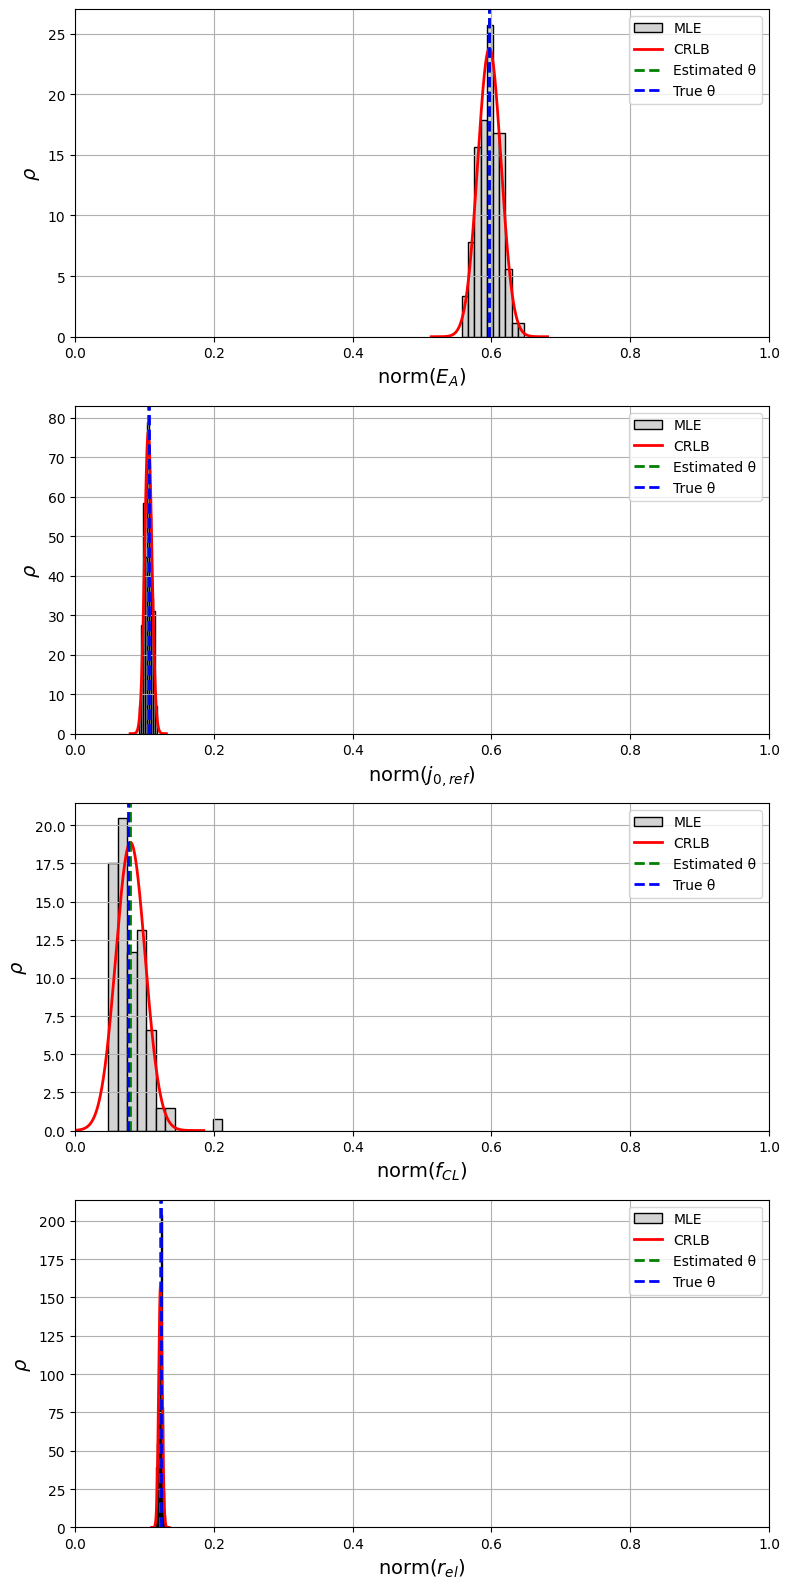

In [9]:
parameter_names = [r'$\mathrm{norm}(E_A)$', r'$\mathrm{norm}(j_{0,ref})$', r"$\mathrm{norm}(f_{CL})$",
                   r"$\mathrm{norm}(r_{el})$"]

plot_mle_vs_crlb(
    scaled_estimated_thetas,  # <== this should be the MLE estimates!
    diagonal_CRLB_LH_experiment,  # <== this should be the CRLB variances!
    scaled_theta_true,
    scaled_lower_bounds_theta,
    scaled_upper_bounds_theta,
    param_names=parameter_names,
)

## Plot design Points of LHC Experiments

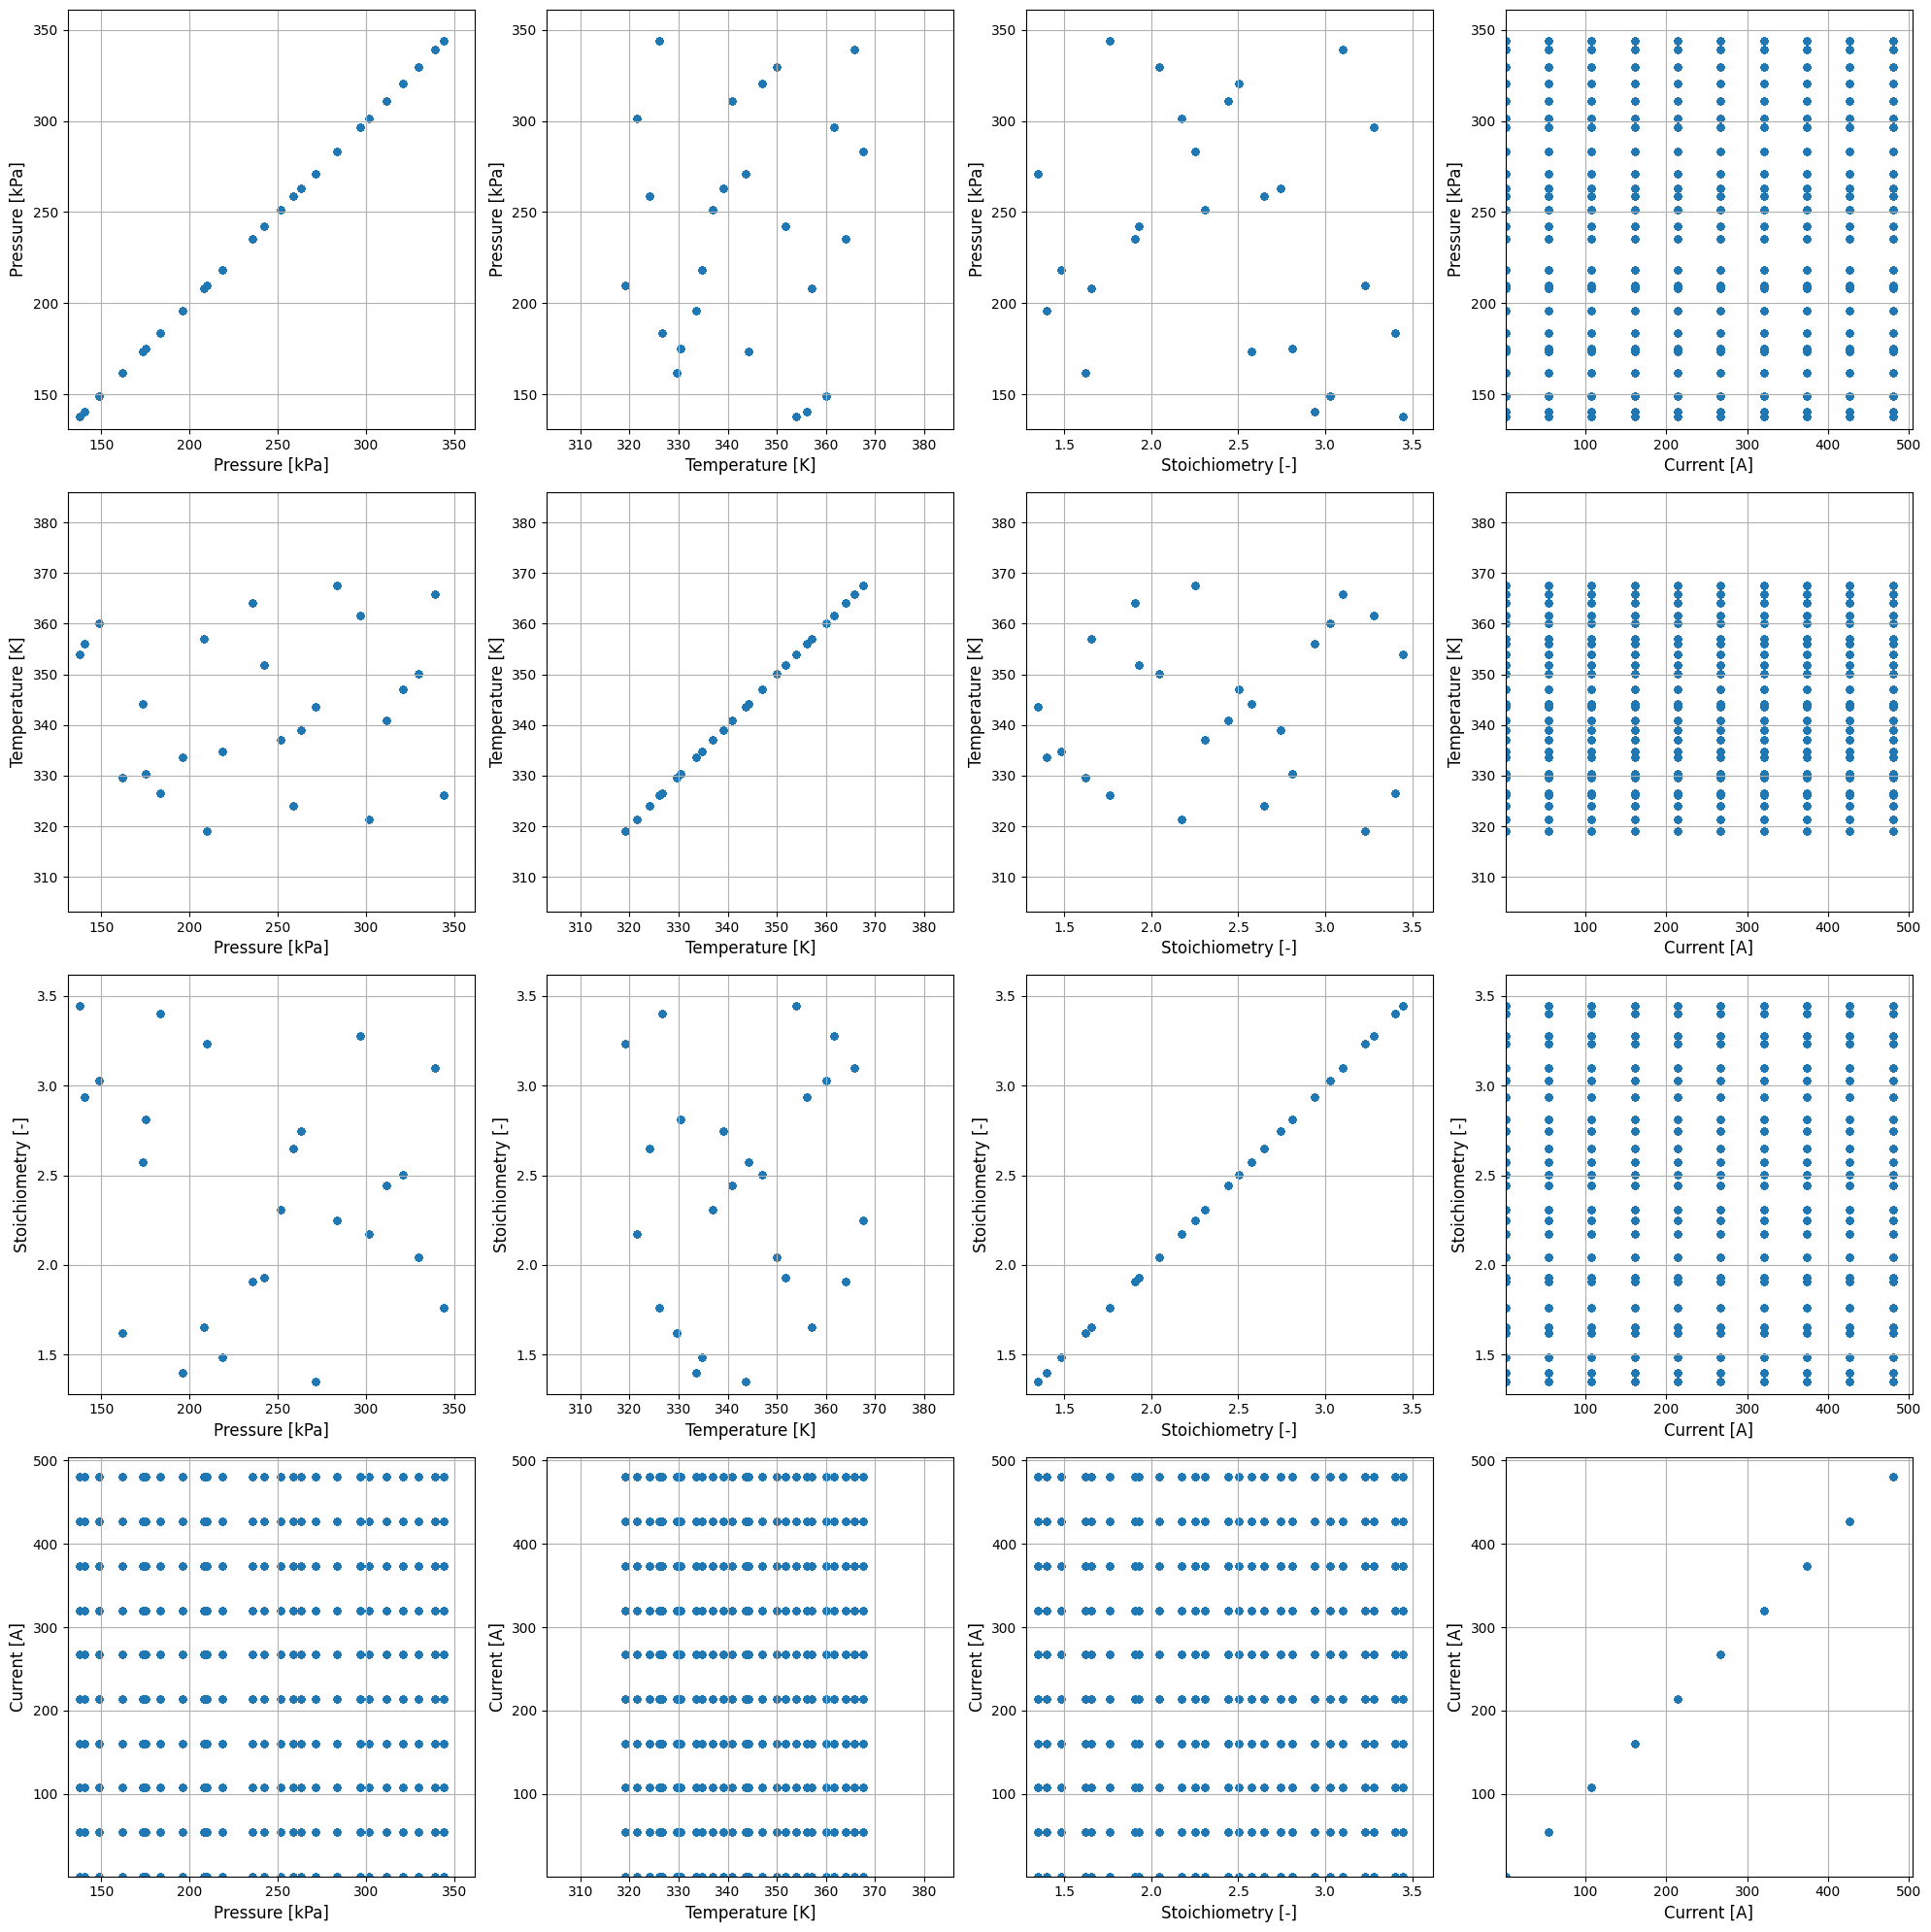

In [10]:
opCons = ["Pressure [kPa]", "Temperature [K]", "Stoichiometry [-]", "Current [A]"]
plot_experiment_matrix([x_designs], opCons)

# Import additional Experiments for optimality criteria

In [11]:
# Load all_additional experiments (LHC + others)
df_all = import_all_experiments(".." / Path("data") / "experimental_designs" / "other")
experiments = {name: group for name, group in df_all.groupby("SourceFile")}

# Designs singular with 5 additional Experiments
in total n_number_new_designs (default: 5) * n_current_values * n_rep = 5000

In [12]:
x_designs_all = {
    "LH_new": experiments["LH_new"][['Pressure','Temperature','Stoichiometry','Current']].to_numpy(),
    "a_design": experiments["a_design"][['Pressure','Temperature','Stoichiometry','Current']].to_numpy(),
    "d_design": experiments["d_design"][['Pressure','Temperature','Stoichiometry','Current']].to_numpy(),
    "pi_design": experiments["pi_design"][['Pressure','Temperature','Stoichiometry','Current']].to_numpy(),
}

y_designs_all = {
    "LH_new": experiments["LH_new"][['Voltage']].to_numpy(),
    "a_design": experiments["a_design"][['Voltage']].to_numpy(),
    "d_design": experiments["d_design"][['Voltage']].to_numpy(),
    "pi_design": experiments["pi_design"][['Voltage']].to_numpy(),
}

In [13]:
results_dict, results_df = evaluate_full_metrics(
    statistical_model=statistical_model,
    scaled_theta_true=scaled_theta_true,
    x_designs=x_designs_all,
    y_designs=y_designs_all,
    n_current_values=n_current_values,
    n_rep=n_rep,
    minimizer=minimizer
)

Estimating thetas: 100%|██████████| 100/100 [05:55<00:00,  3.55s/it]


In [14]:
print(results_df)

theta_df = pd.DataFrame({
    "Design": list(results_dict.keys()),
    **{f"θ_{i+1}": [results_dict[d]["est_theta"][i] for d in results_dict] for i in range(len(results_dict.keys()))},
    **{f"σ_rel(θ_{i+1})": [results_dict[d]["rel_std"][i] for d in results_dict] for i in range(len(results_dict.keys()))},
    **{f"CRLB(θ_{i+1})": [results_dict[d]["diag_CRLB"][i] for d in results_dict] for i in range(len(results_dict.keys()))},
})

print(theta_df)

  Experiment       det_FIM                                          diag_CRLB  \
0     LH_new  1.952418e+22  [2.0279648824122315e-05, 1.5267412443507737e-0...   
1   a_design  1.890615e+23  [6.007644680000942e-06, 1.3017417175798427e-06...   
2   d_design  3.812029e+24  [5.96947701699e-06, 1.3196516340698562e-06, 7....   
3  pi_design  7.797824e+22  [3.131589948052693e-05, 1.317455119669897e-06,...   

                                             rel_std  \
0  [0.007559260345988308, 0.011596283535032234, 0...   
1  [0.004079570447574915, 0.01069398809379056, 0....   
2  [0.004055890903101971, 0.010778374875958844, 0...   
3  [0.00935890430784613, 0.010680925374113394, 0....   

                                           rel_error  \
0  [0.00038193728314515776, 0.005382432509956112,...   
1  [0.008140043050190629, 0.006676925743165932, 0...   
2  [0.010799597993448963, 0.00564283647628625, 0....   
3  [0.00332266115889254, 0.013973098224010414, 0....   

                                

In [15]:
# Make a 2D array: rows = designs, columns = parameters
design_names = ["LH_new", "a_design", "d_design", "pi_design"]

# Collect estimated thetas from results_df
scaled_estimated_thetas = np.array([
    results_df.loc[results_df["Experiment"] == name, "est_thetas"].values[0]
    for name in design_names
])

# Collect CRLB diagonals from results_df
diagonal_CRLB_experiment = np.array([
    results_df.loc[results_df["Experiment"] == name, "diag_CRLB"].values[0]
    for name in design_names
])

LH_new


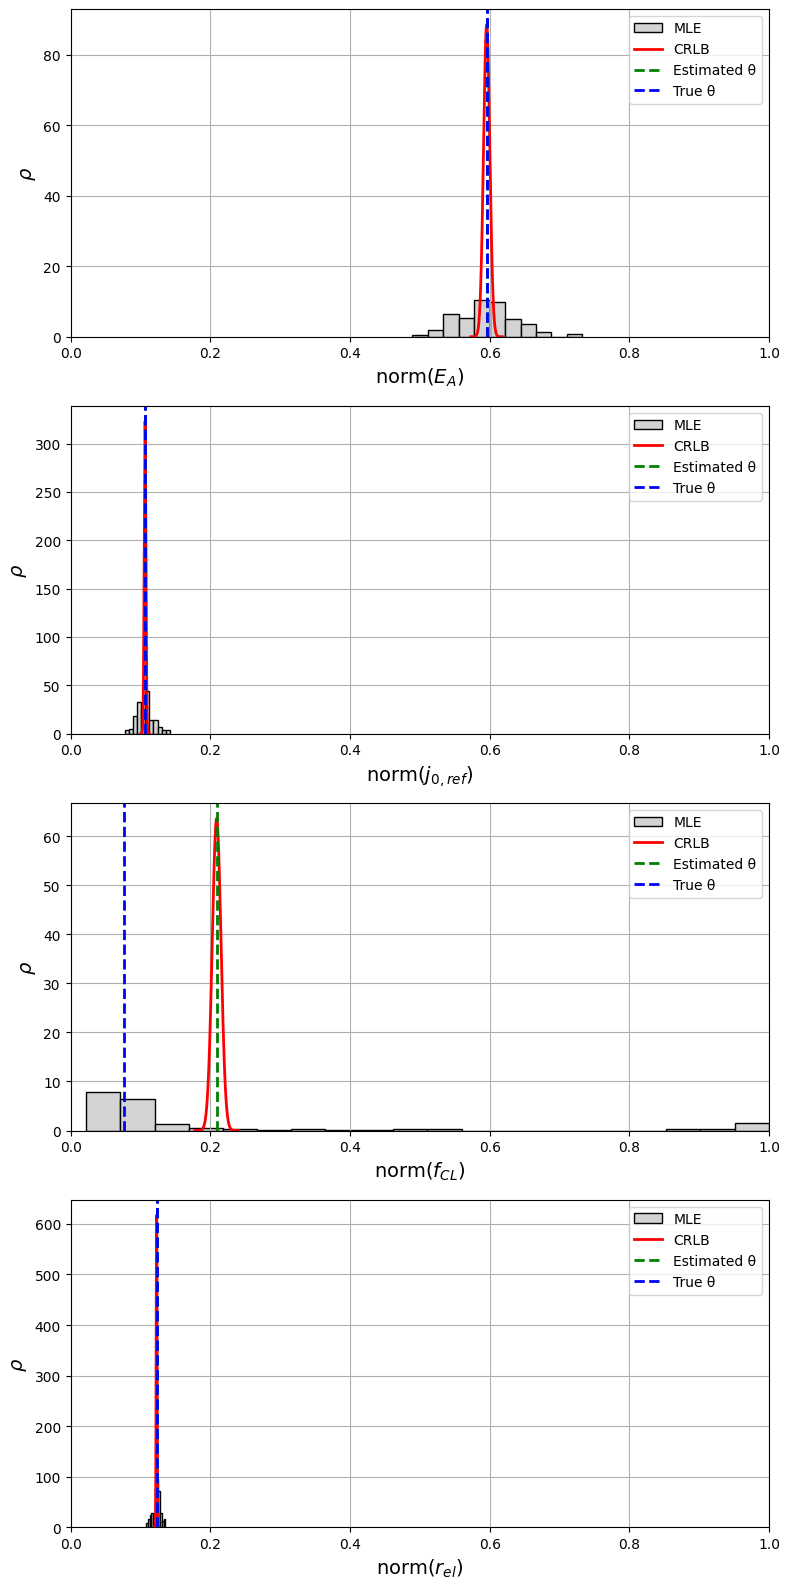

a_design


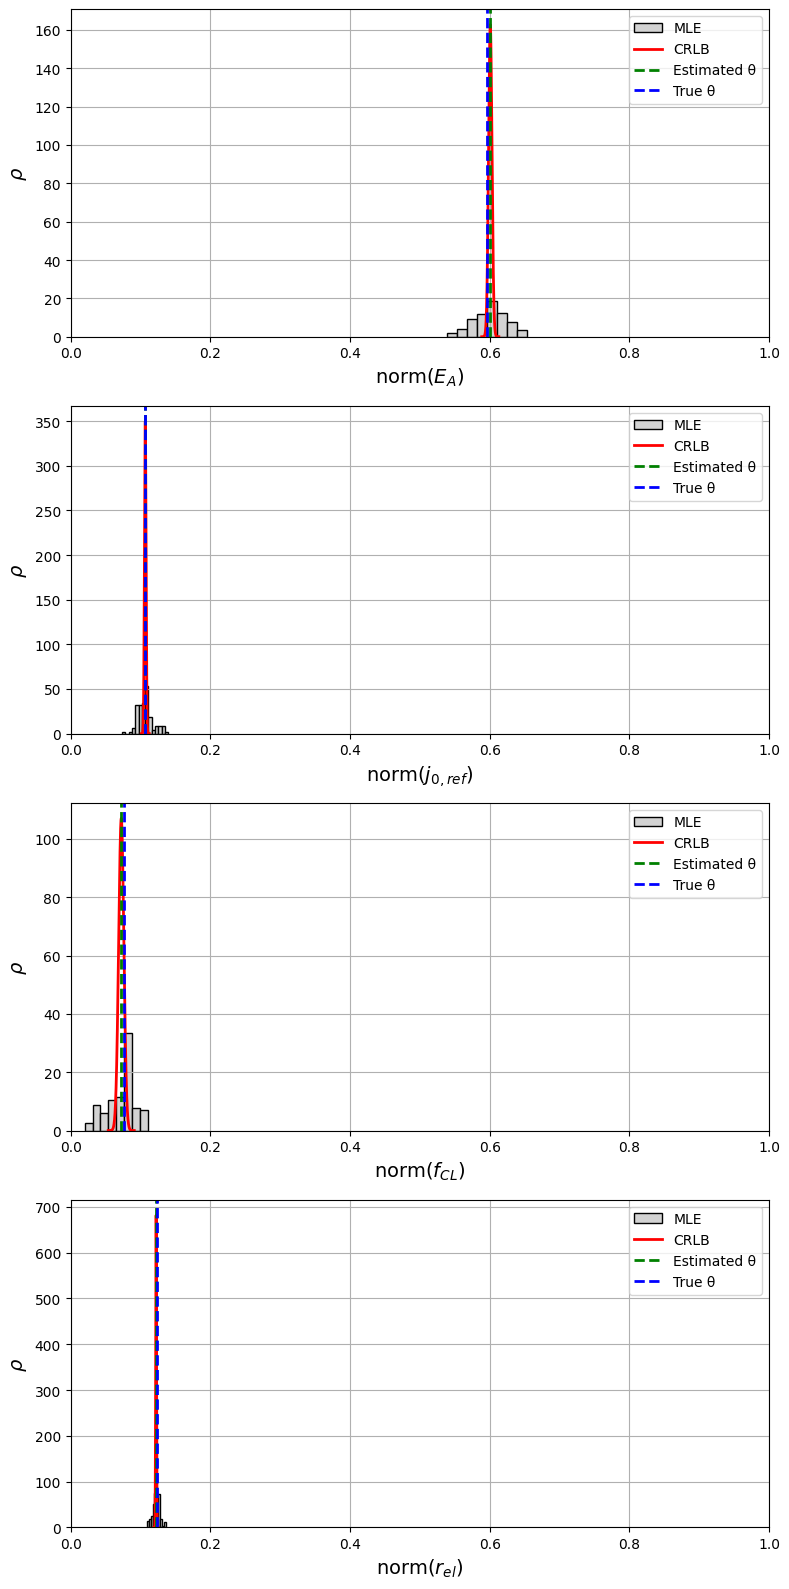

d_design


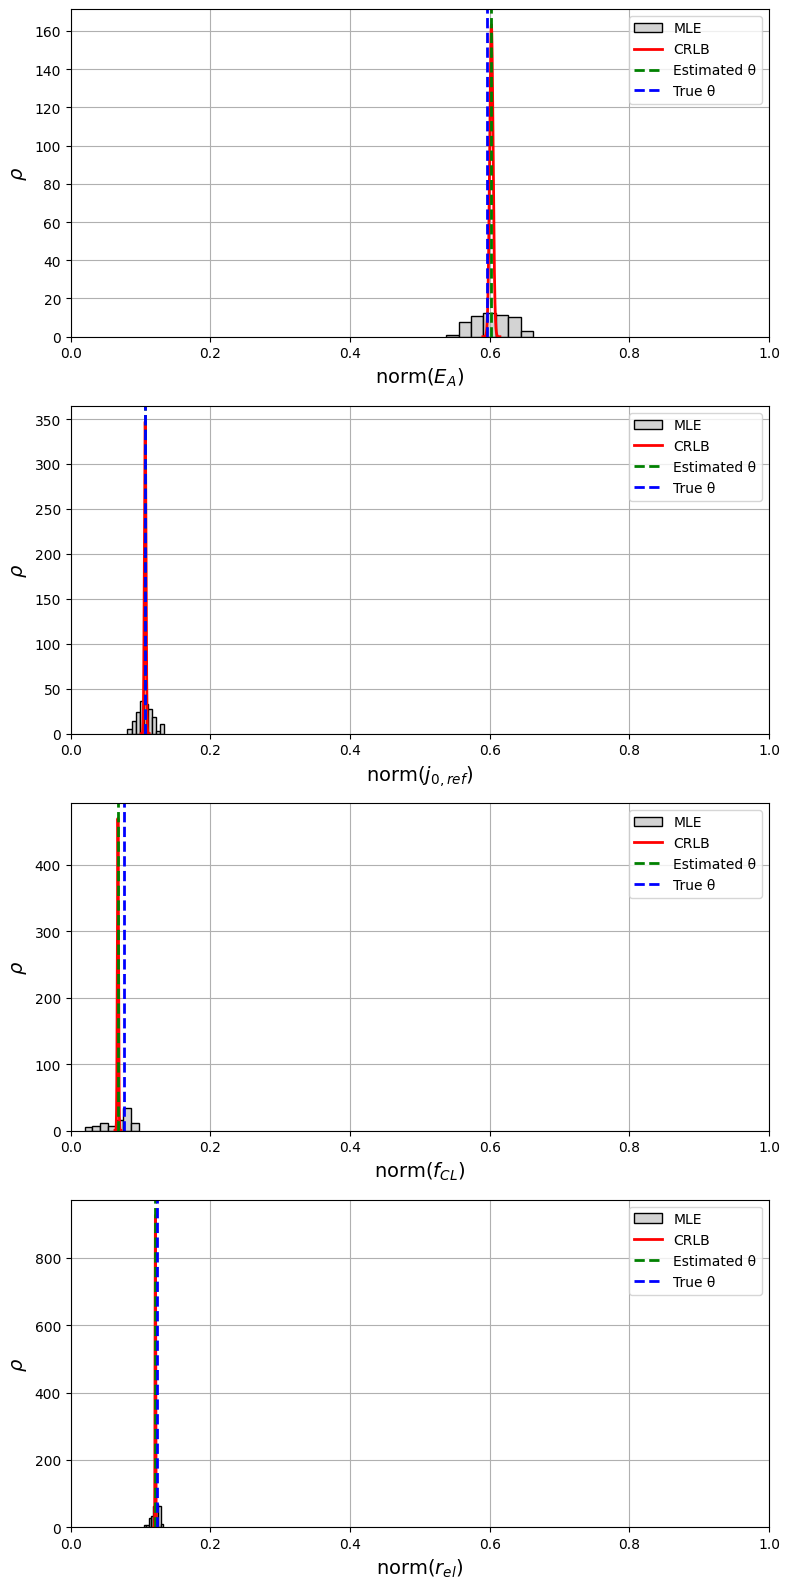

pi_design


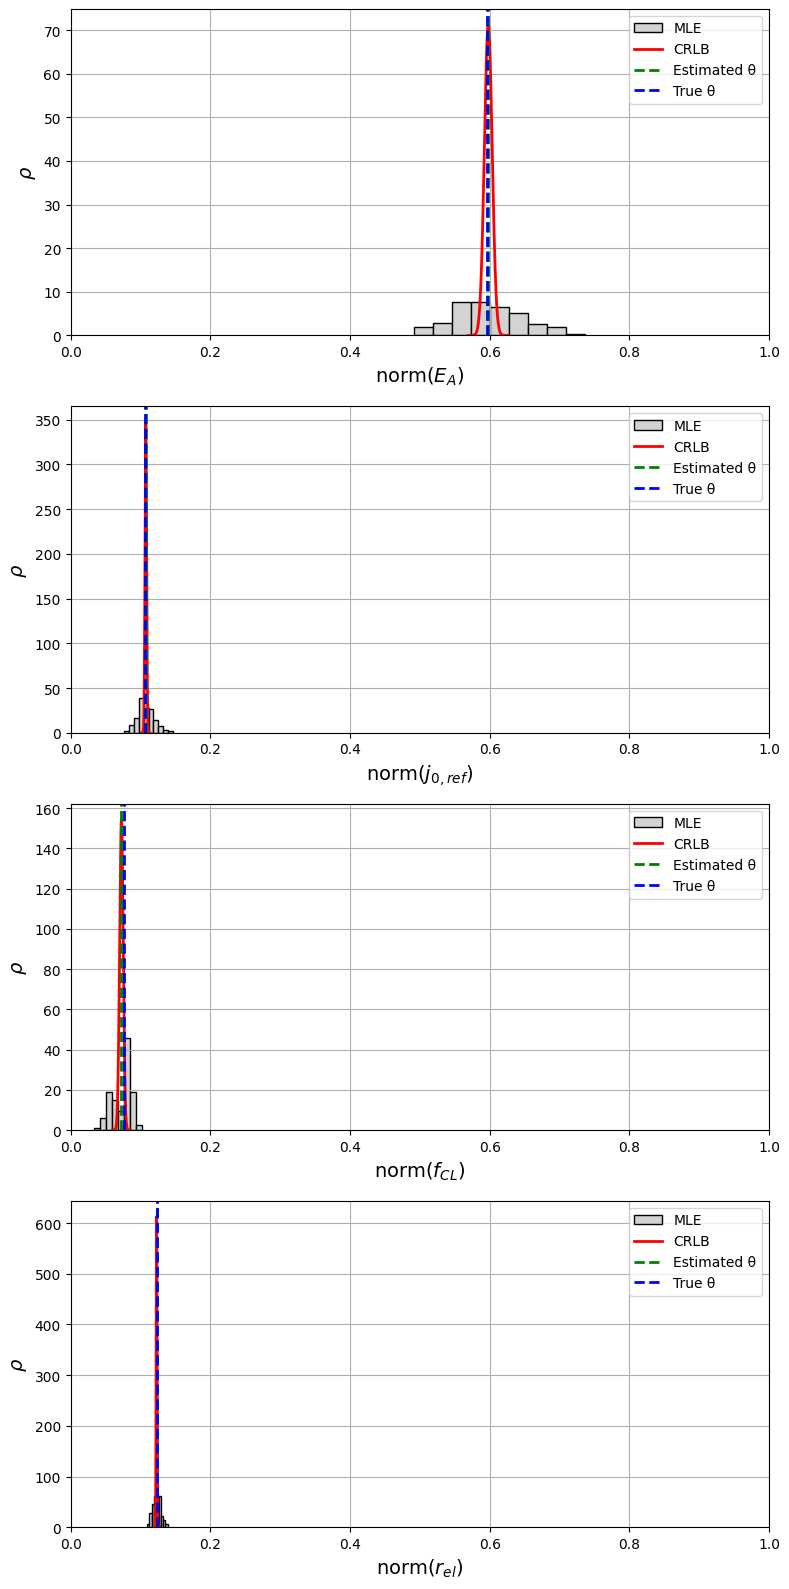

In [16]:
for i, name in enumerate(design_names):
    parameter_names = [r'$\mathrm{norm}(E_A)$', r'$\mathrm{norm}(j_{0,ref})$',
               r"$\mathrm{norm}(f_{CL})$", r"$\mathrm{norm}(r_{el})$"]

    print(name)
    print(50* "=")

    plot_mle_vs_crlb(
        scaled_estimated_thetas[i],           # MLE estimates from results_dict
        diagonal_CRLB_experiment[i],       # CRLB variances from results_dict
        scaled_theta_true,                 # true parameters
        scaled_lower_bounds_theta,         # lower bounds
        scaled_upper_bounds_theta,         # upper bounds
        param_names=parameter_names,
        )

    print(50* "=")

# All Designs stacked with 25LH + 5 additional Experiments
in total (number_designs (default: 25) + n_number_new_designs (default: 5)) * n_current_values * n_rep = 30000

In [17]:
cols_x = ['Pressure','Temperature','Stoichiometry','Current']
cols_y = ['Voltage']
design_names = ["LH_new", "a_design", "d_design", "pi_design"]

x_designs_all_stacked = {
    name: np.vstack([x_designs, experiments[name][cols_x].to_numpy()])
    for name in design_names
}

y_designs_all_stacked = {
    name: np.vstack([y_designs, experiments[name][cols_y].to_numpy().reshape(-1, 1)])
    for name in design_names
}

for k in x_designs_all_stacked:
    print(k, x_designs_all_stacked[k].shape, y_designs_all_stacked[k].shape)

LH_new (30000, 4) (30000, 1)
a_design (30000, 4) (30000, 1)
d_design (30000, 4) (30000, 1)
pi_design (30000, 4) (30000, 1)


In [ ]:
results_dict, results_df = evaluate_full_metrics(
    statistical_model=statistical_model,
    scaled_theta_true=scaled_theta_true,
    x_designs=x_designs_all_stacked,
    y_designs=y_designs_all_stacked,
    n_current_values=n_current_values,
    n_rep=n_rep,
    minimizer=minimizer
)

Estimating thetas: 100%|██████████| 100/100 [18:54<00:00, 11.34s/it]


In [19]:
print(len(results_df))

theta_df = pd.DataFrame({
    "Design": list(results_dict.keys()),
    **{f"θ_{i+1}": [results_dict[d]["est_theta"][i] for d in results_dict] for i in range(len(results_dict.keys()))},
    **{f"σ_rel(θ_{i+1})": [results_dict[d]["rel_std"][i] for d in results_dict] for i in range(len(results_dict.keys()))},
    **{f"CRLB(θ_{i+1})": [results_dict[d]["diag_CRLB"][i] for d in results_dict] for i in range(len(results_dict.keys()))},
})
print(theta_df)

4
      Design       θ_1       θ_2       θ_3       θ_4  σ_rel(θ_1)  σ_rel(θ_2)  \
0     LH_new  0.595561  0.105782  0.084364  0.122942    0.002606    0.004509   
1   a_design  0.596579  0.105869  0.084196  0.122975    0.002294    0.004483   
2   d_design  0.597554  0.105905  0.084069  0.122857    0.002466    0.004420   
3  pi_design  0.596957  0.105575  0.083514  0.122836    0.002559    0.004405   

   σ_rel(θ_3)  σ_rel(θ_4)  CRLB(θ_1)     CRLB(θ_2)  CRLB(θ_3)     CRLB(θ_4)  
0    0.023608    0.001936   0.000002  2.275003e-07   0.000004  5.667750e-08  
1    0.018736    0.001779   0.000002  2.252232e-07   0.000002  4.784911e-08  
2    0.021668    0.001936   0.000002  2.190947e-07   0.000003  5.657386e-08  
3    0.023594    0.001918   0.000002  2.162412e-07   0.000004  5.552291e-08  


In [20]:
# Make a 2D array: rows = designs, columns = parameters
design_names = ["LH_new", "a_design", "d_design", "pi_design"]

# Collect estimated thetas from results_df
scaled_estimated_thetas = np.array([
    results_df.loc[results_df["Experiment"] == name, "est_thetas"].values[0]
    for name in design_names
])

# Collect CRLB diagonals from results_df
diagonal_CRLB_experiment = np.array([
    results_df.loc[results_df["Experiment"] == name, "diag_CRLB"].values[0]
    for name in design_names
])

LH_new


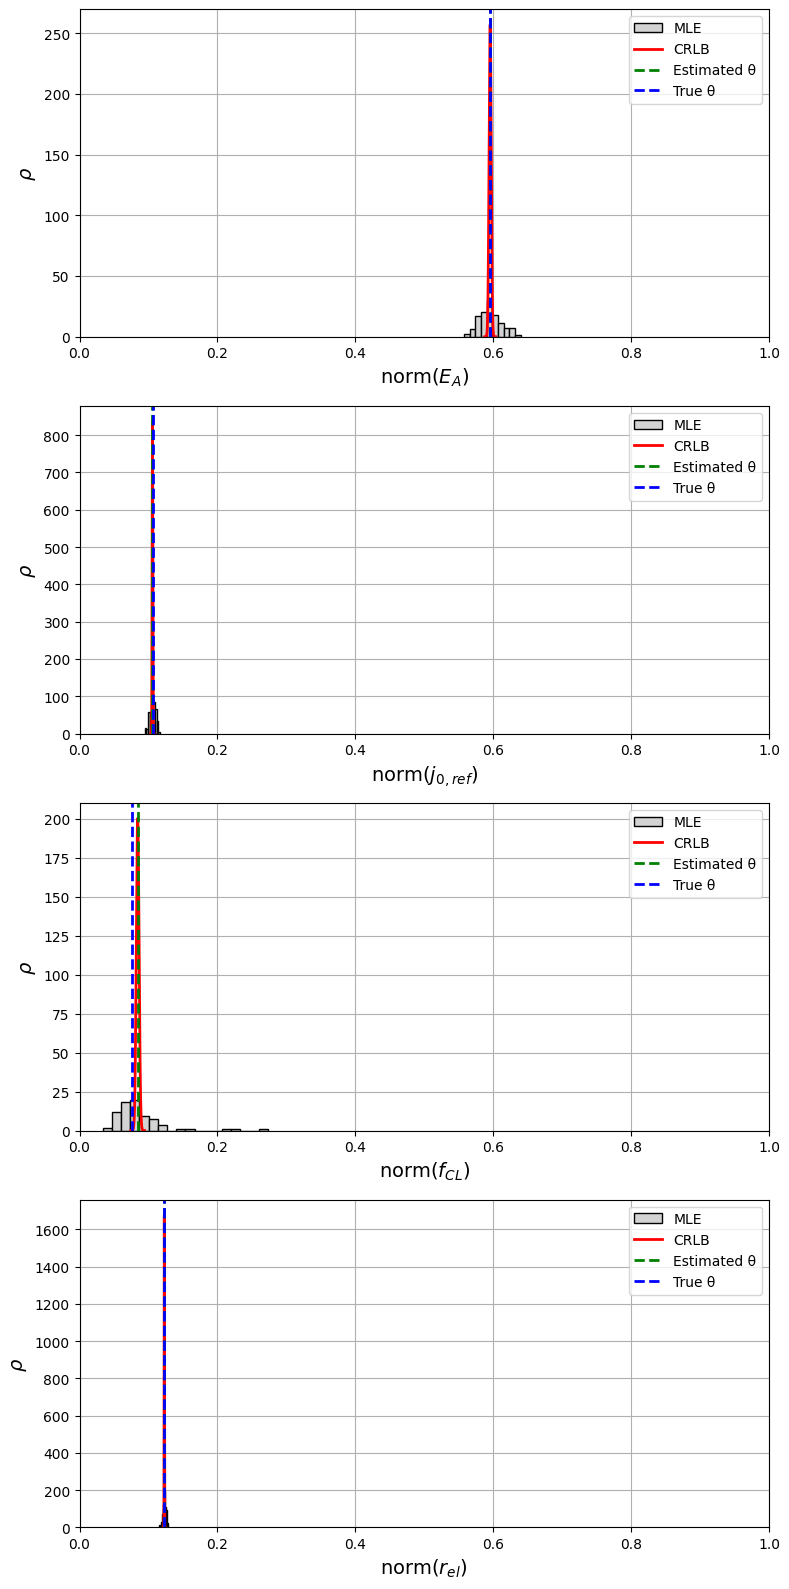

a_design


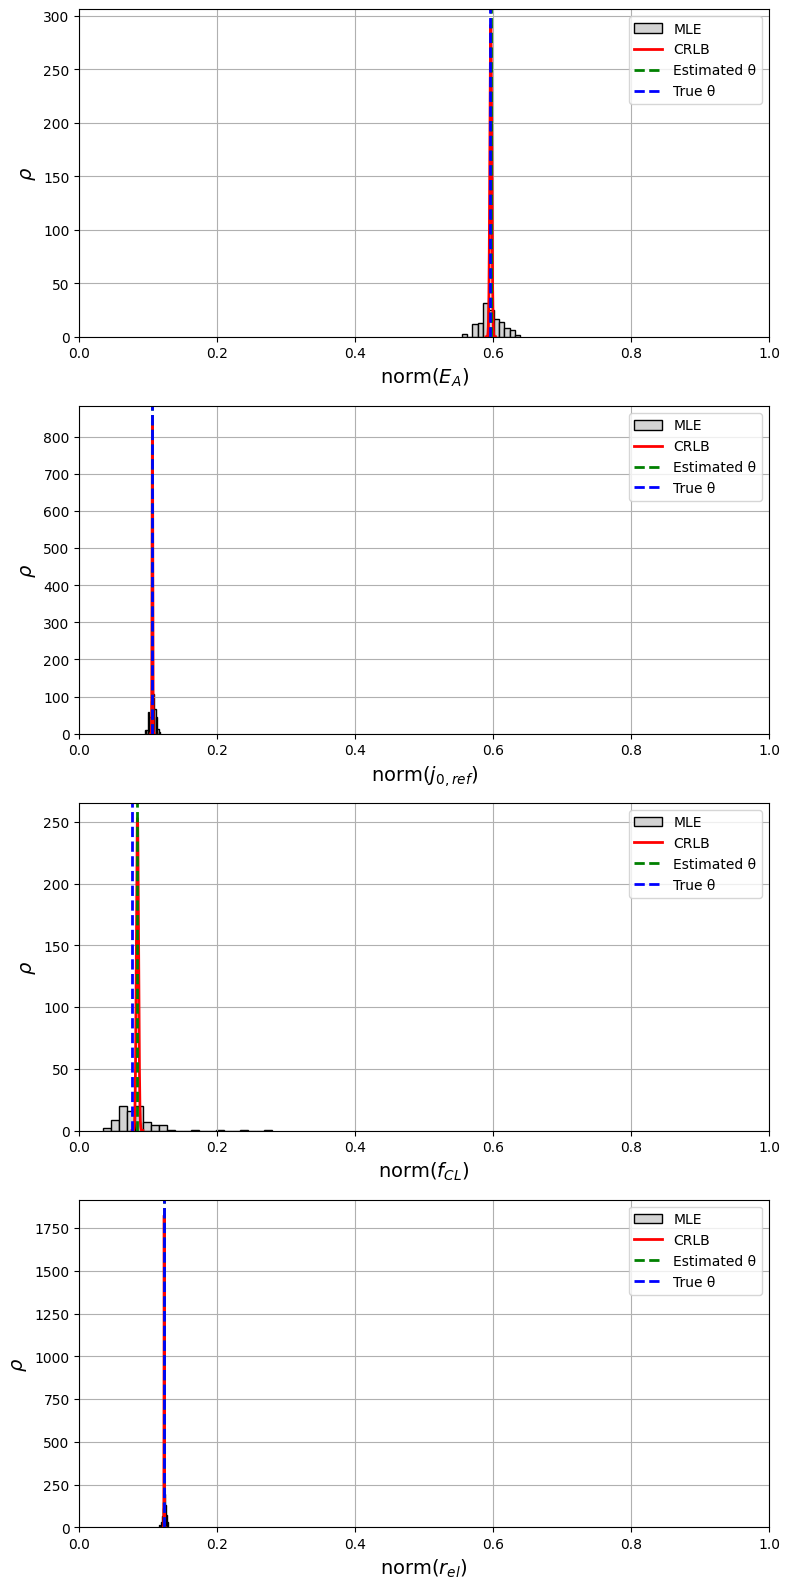

d_design


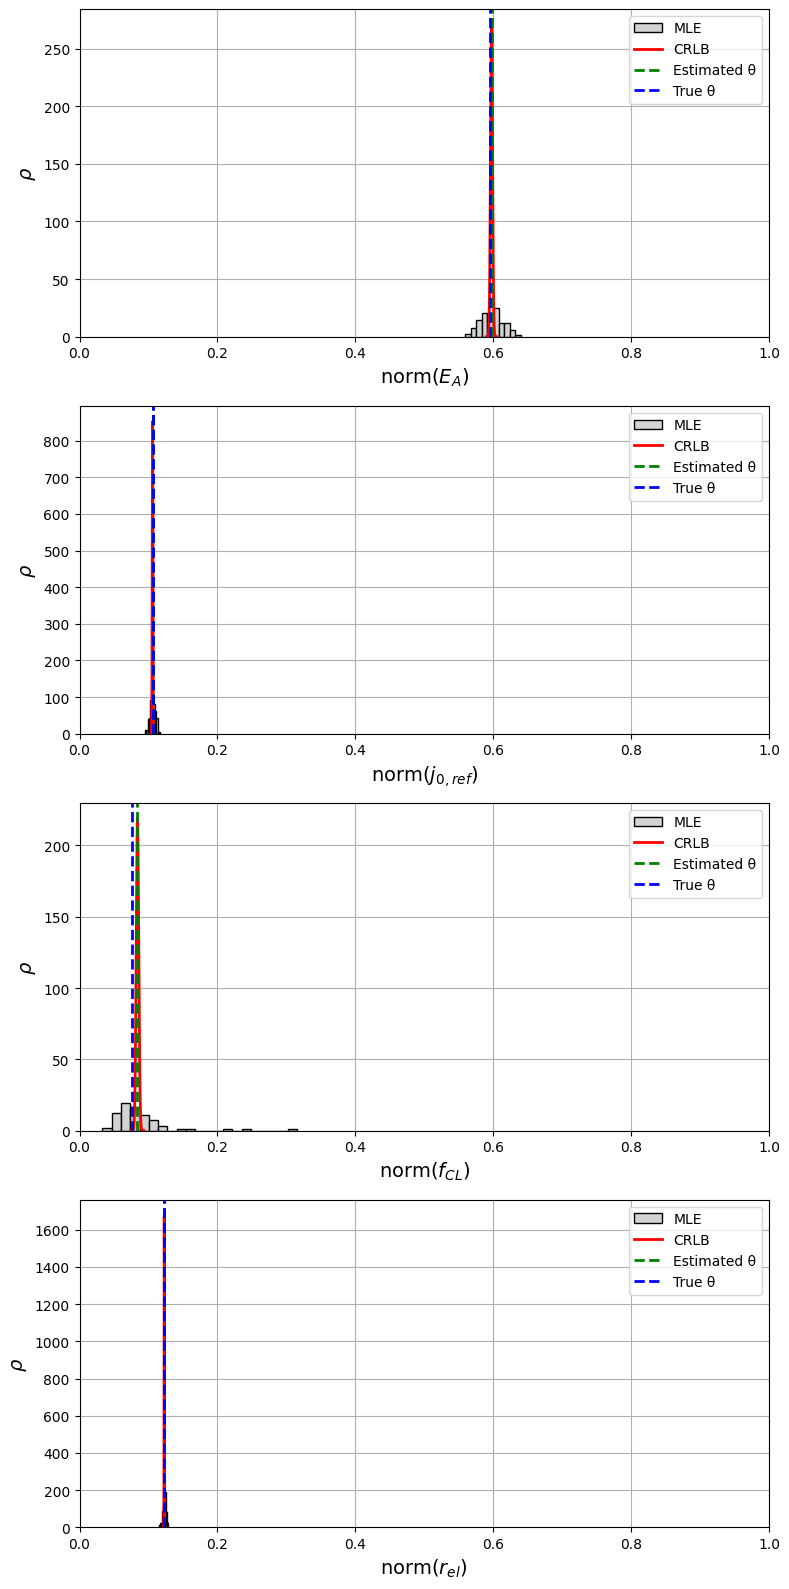

pi_design


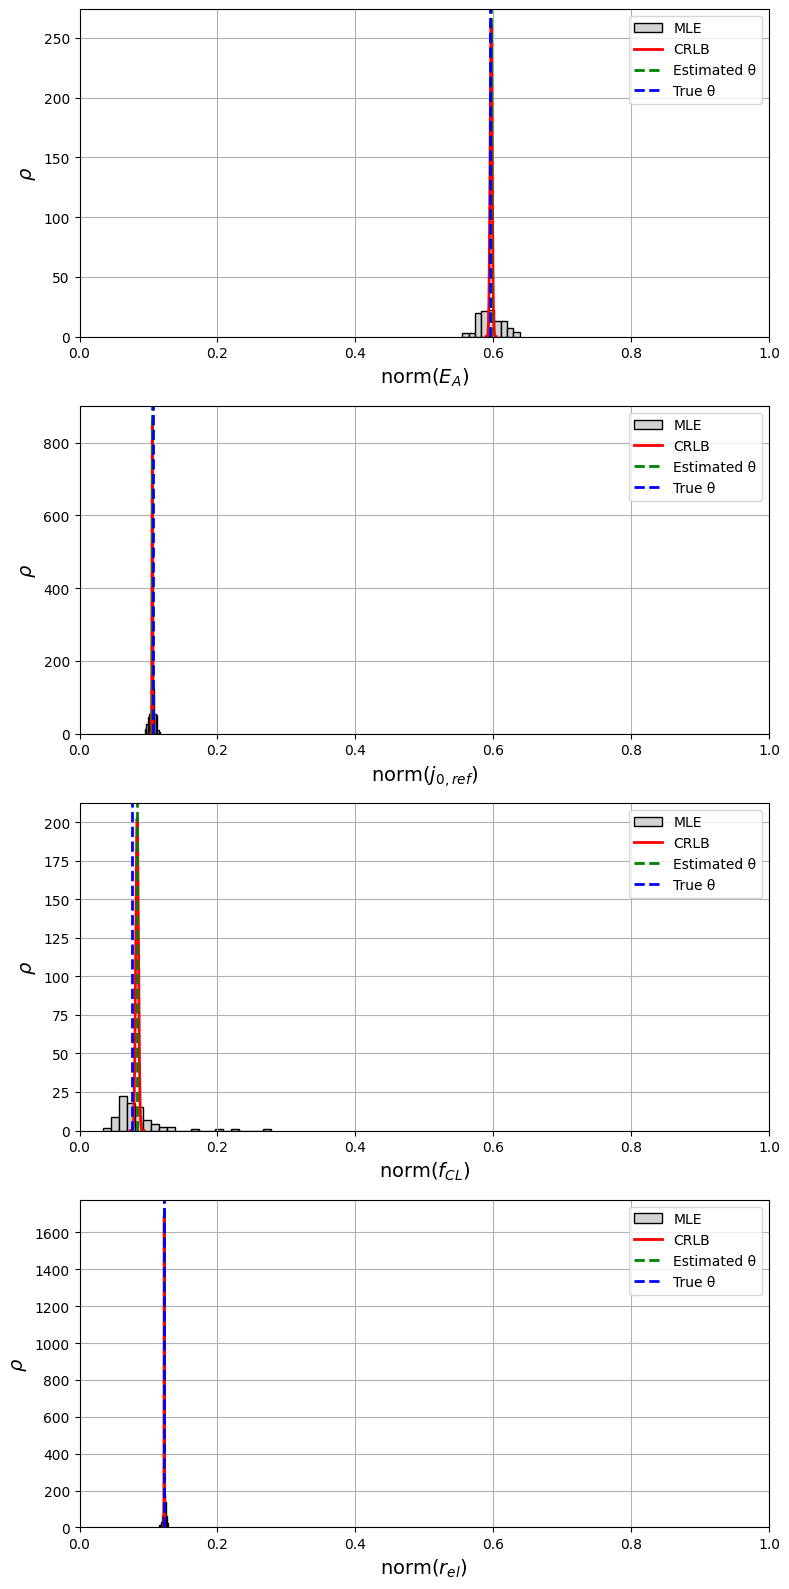

In [21]:
for i, name in enumerate(design_names):
    parameter_names = [r'$\mathrm{norm}(E_A)$', r'$\mathrm{norm}(j_{0,ref})$',
               r"$\mathrm{norm}(f_{CL})$", r"$\mathrm{norm}(r_{el})$"]

    print(name)
    print(50* "=")

    plot_mle_vs_crlb(
        scaled_estimated_thetas[i],           # MLE estimates from results_dict
        diagonal_CRLB_experiment[i],       # CRLB variances from results_dict
        scaled_theta_true,                 # true parameters
        scaled_lower_bounds_theta,         # lower bounds
        scaled_upper_bounds_theta,         # upper bounds
        param_names=parameter_names,
        )

    print(50* "=")